In [1]:
import keras
keras.__version__

'2.10.0'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 7s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### 1 不使用数据增强的特征提取

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'D:\PyCharm_project\deep-learning-with-python-notebooks\\first_edition\datasets\cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 18ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 18ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 20ms/step


The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [17]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 11ms/step - loss: 0.6222 - acc: 0.6465 - val_loss: 0.4552 - val_acc: 0.8320
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4356 - acc: 0.8060 - val_loss: 0.3711 - val_acc: 0.8650
Epoch 3/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3679 - acc: 0.8400 - val_loss: 0.3276 - val_acc: 0.8860
Epoch 4/30
100/100 [==============================] - 1s 5ms/step - loss: 0.3213 - acc: 0.8670 - val_loss: 0.3062 - val_acc: 0.8780
Epoch 5/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2874 - acc: 0.8830 - val_loss: 0.2925 - val_acc: 0.8810
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2746 - acc: 0.8920 - val_loss: 0.2756 - val_acc: 0.8940
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.2455 - acc: 0.9000 - val_loss: 0.2710 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 1s 5ms/step - loss: 0

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

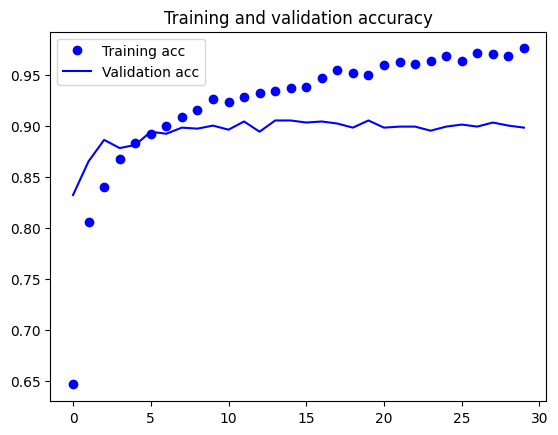

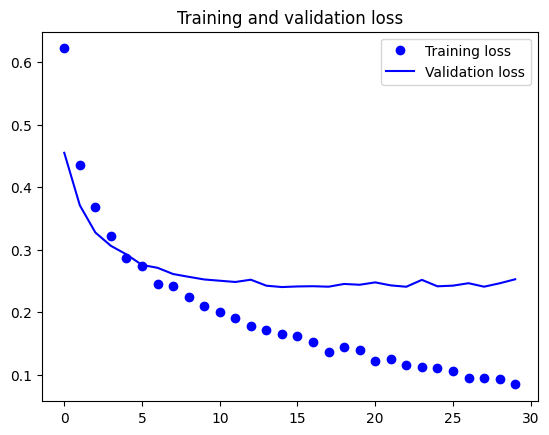

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2 使用数据增强的特征提取

In [19]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [11]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [20]:
conv_base.trainable = False

In [13]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


C:\Users\zhuqin\AppData\Local\Temp\ipykernel_8592\77119917.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 12s - loss: 0.5917 - acc: 0.6895 - val_loss: 0.4576 - val_acc: 0.8190 - 12s/epoch - 119ms/step
Epoch 2/30
100/100 - 11s - loss: 0.4768 - acc: 0.7875 - val_loss: 0.3813 - val_acc: 0.8600 - 11s/epoch - 114ms/step
Epoch 3/30
100/100 - 12s - loss: 0.4336 - acc: 0.8115 - val_loss: 0.3287 - val_acc: 0.8720 - 12s/epoch - 121ms/step
Epoch 4/30
100/100 - 14s - loss: 0.4067 - acc: 0.8270 - val_loss: 0.3048 - val_acc: 0.8780 - 14s/epoch - 136ms/step
Epoch 5/30
100/100 - 13s - loss: 0.3775 - acc: 0.8385 - val_loss: 0.2995 - val_acc: 0.8670 - 13s/epoch - 134ms/step
Epoch 6/30
100/100 - 14s - loss: 0.3868 - acc: 0.8255 - val_loss: 0.2829 - val_acc: 0.8870 - 14s/epoch - 138ms/step
Epoch 7/30
100/100 - 14s - loss: 0.3535 - acc: 0.8480 - val_loss: 0.2858 - val_acc: 0.8860 - 14s/epoch - 139ms/step
Epoch 8/30
100/100 - 14s - loss: 0.3415 - acc: 0.8505 - val_loss: 0.2870 - val_acc: 0.8880 - 14s/epoch - 139ms/step
Epoch 9/30
100/100 - 14s - loss: 0.3355 - acc: 0.8565 - val_loss: 0.2665 - val_acc:

In [24]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

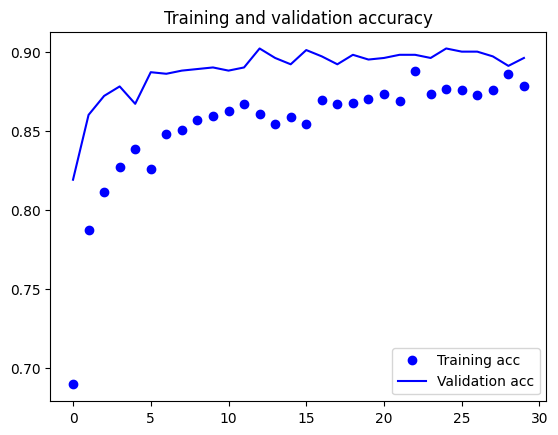

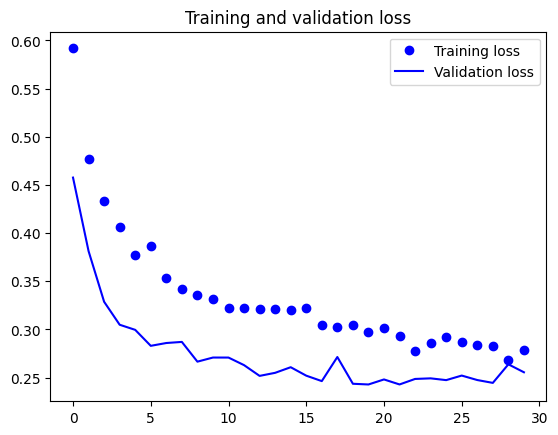

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

### 3. Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [36]:
# 将block5_conv1 以及之后层的layer.trainable 都修改成可以训练的了

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
# 简化上述代码的错误示范，只将block5_conv1的layer.trainable 都修改成可以训练的了
conv_base.trainable = True

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [35]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=5,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/5


C:\Users\zhuqin\AppData\Local\Temp\ipykernel_8592\2756585418.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 16s 153ms/step - loss: 0.0112 - acc: 0.9970 - val_loss: 0.2739 - val_acc: 0.9440
Epoch 2/5
100/100 [==============================] - 16s 155ms/step - loss: 0.0127 - acc: 0.9955 - val_loss: 0.2897 - val_acc: 0.9430
Epoch 3/5
100/100 [==============================] - 16s 156ms/step - loss: 0.0094 - acc: 0.9965 - val_loss: 0.3013 - val_acc: 0.9380
Epoch 4/5
100/100 [==============================] - 17s 171ms/step - loss: 0.0105 - acc: 0.9950 - val_loss: 0.3252 - val_acc: 0.9360
Epoch 5/5
100/100 [==============================] - 16s 157ms/step - loss: 0.0099 - acc: 0.9970 - val_loss: 0.3359 - val_acc: 0.9380


In [29]:
model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

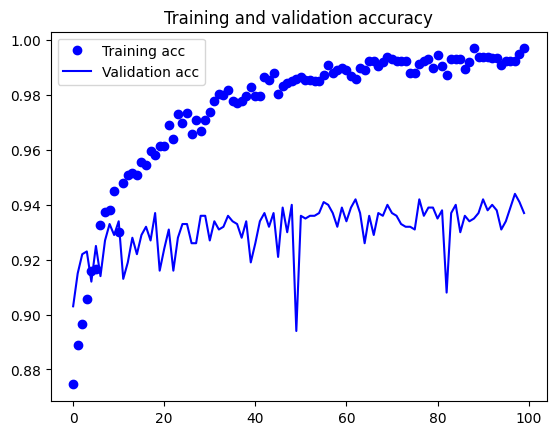

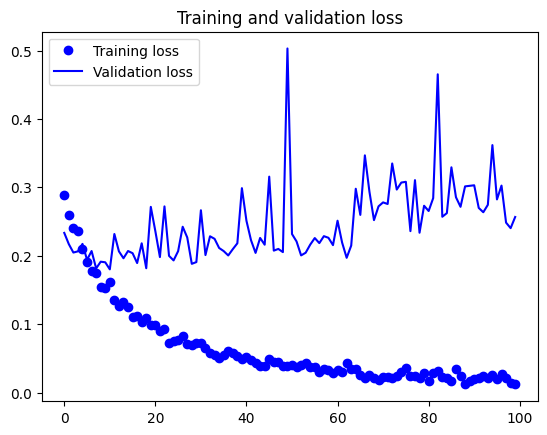

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

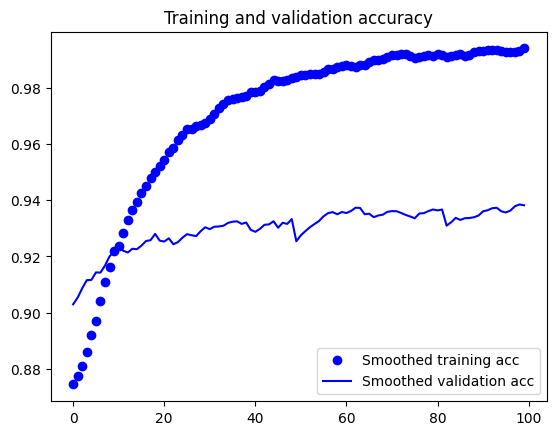

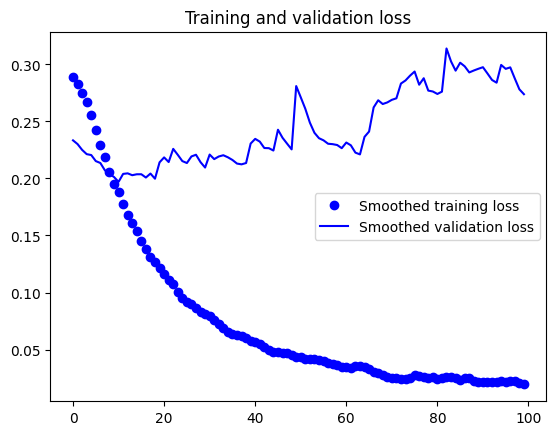

In [31]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [32]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\zhuqin\AppData\Local\Temp\ipykernel_8592\2632914869.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9409999847412109



Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with 
small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously 
learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.